## Overview

This notebook covers preliminary work into fitting an equivalent circuit model (ECM) to Electrochemical Impedance Spectroscopy (EIS) data. 

In [1]:
import pandas as pd
import numpy as np
from impedance.models.circuits import CustomCircuit
from impedance import preprocessing
from impedance.visualization import plot_nyquist
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

def remove_zeros(file_path, create_new_file):
    """
    Remove rows with zeros from the input file and, optionally, save the cleaned data to a new file.

    Parameters:
    file_path (str): Path to the input file.
    create_new_file (bool): If True, a new file with the cleaned data will be created.

    Returns:
    pd.DataFrame: DataFrame with the cleaned data.

    """
    df = pd.read_csv(file_path, sep='\t', header=None, skiprows=1)

    df = df.apply(pd.to_numeric, errors='coerce')

    #Set column names
    df.columns = ["|Z|/Ohm", "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm", "cycle number"]

    #Remove zeros
    df_filtered = df[(df[['|Z|/Ohm', 'freq/Hz', 'Re(Z)/Ohm', '-Im(Z)/Ohm', 'cycle number']] != 0).all(axis=1)]

    if create_new_file == True:
        base_name = os.path.basename(file_path)
        name, ext = os.path.splitext(base_name)
        output_file_name = f"{name}_clean{ext}"
        output_file_path = os.path.join(os.path.dirname(file_path), output_file_name)
        df_filtered.to_csv(output_file_path, sep='\t', index=False, header=False)

    column_headers = df.iloc[0]

    return df_filtered

import plotly.graph_objects as go

def plot_single_spectrum(df, battery_name, show_frequency_gradient):
    """
    Plot the impedance spectrum of the battery.

    Parameters:
    df (pd.DataFrame): DataFrame with the impedance data.
    battery_name (str): Name of the battery.
    show_frequency_gradient (bool): If True, the points will be colored according to the frequency.

    """
    
    cycle_column, re_column, im_column, freq_column = 'cycle number', 'Re(Z)/Ohm', '-Im(Z)/Ohm', 'freq/Hz'
    fig = go.Figure()
    
    cycles = df[cycle_column].unique()
    traces = []
    buttons = []

    for i, cycle in enumerate(cycles):
        df_cycle = df[df[cycle_column] == cycle]
        if show_frequency_gradient:
            marker = dict(
                size=7, 
                color=df_cycle[freq_column], 
                colorscale='Viridis', 
                colorbar=dict(
                    title='Frequency (Hz)',
                    thickness=15,
                    len=0.5
                )
            )
        else:
            marker = dict(
                size=5.5,
            )
        
        trace = go.Scatter(
            x=df_cycle[re_column], 
            y=df_cycle[im_column], 
            mode='markers', 
            name=f'Cycle {int(cycle)}', 
            marker=marker,
        )
        traces.append(trace)

    initial_visibility = [False] * len(cycles)
    for i, cycle in enumerate(cycles):
        button = dict(
            method='update',
            label=f'Cycle {int(cycle)}',
            visible=True,
            args=[{'visible': [(not visibility) if j == i else visibility for j, visibility in enumerate(initial_visibility)]},
                  {'title': f'Impedance Plot of Battery {battery_name}'}]
        )
        buttons.append(button)

    all_button = dict(method='update', label='All', visible=True, args=[{'visible': [True] * len(traces)}])
    buttons.append(all_button)

    fig.update_layout(
        autosize=False, 
        width=800, 
        height=600,
        updatemenus=[
            dict(
                type='buttons',
                direction='right',
                x=1.1,
                y=1.1,
                buttons=buttons
            )
        ],
        title=f'Impedance Plot of Battery {battery_name}',
        xaxis_title='Re(Z)/Ohm',
        yaxis_title='-Im(Z)/Ohm',
        #yaxis=dict(range=[0, 0.01]),
        #xaxis=dict(range=[0.04, 0.065]),
        showlegend=True,
        legend=dict(orientation='v', x=1.02, y=1)
    )

    for trace in traces:
        fig.add_trace(trace)

    fig.show()



In [2]:
file_paths = [
    ('Data/EIS_Data/NX001_2108_EIS.txt'),
    ('Data/EIS_Data/NX001_2401_EIS.txt'),
    ('Data/EIS_Data/NX002_2108_EIS.txt'),
    ('Data/EIS_Data/NX006_2108_EIS.txt'),
    ('Data/EIS_Data/NX006_2401_EIS.txt'),
    ('Data/EIS_Data/RS001_2108_EIS.txt'),
    ('Data/EIS_Data/RS006_2108_EIS.txt'),
    ('Data/EIS_Data/RS006_2401_EIS.txt'),
    ('Data/EIS_Data/SG003_2401_EIS.txt'),
    ('Data/EIS_Data/SG004_2401_EIS.txt'),
    ('Data/EIS_Data/SG007_2108_EIS.txt'),
    ('Data/EIS_Data/SG007_2401_EIS.txt'),
    ('Data/EIS_Data/SG008_2108_EIS.txt'),
    ('Data/EIS_Data/SG009_2108_EIS.txt'),
    ('Data/EIS_Data/SG009_2401_EIS.txt')
]

clean_data = []

for file_path in file_paths:
    df = remove_zeros(file_path, False)
    df.columns = ["|Z|/Ohm", "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm", "cycle number"]
    battery_name = os.path.basename(file_path).split('_EIS.txt')[0]
    clean_data.append((df, battery_name)) 

df_NX001_2108, battery_name_NX001_2108 = clean_data[0]
df_NX001_2401, battery_name_NX001_2401 = clean_data[1]
df_NX002_2108, battery_name_NX002_2108 = clean_data[2]
df_NX006_2108, battery_name_NX006_2108 = clean_data[3]
df_NX006_2401, battery_name_NX006_2401 = clean_data[4]
df_RS001_2108, battery_name_RS001_2108 = clean_data[5]
df_RS006_2108, battery_name_RS006_2108 = clean_data[6]
df_RS006_2401, battery_name_RS006_2401 = clean_data[7]
df_SG003_2401, battery_name_SG003_2401 = clean_data[8]
df_SG004_2401, battery_name_SG004_2401 = clean_data[9]
df_SG007_2108, battery_name_SG007_2108 = clean_data[10]
df_SG007_2401, battery_name_SG007_2401 = clean_data[11]
df_SG008_2108, battery_name_SG008_2108 = clean_data[12]
df_SG009_2108, battery_name_SG009_2108 = clean_data[13]
df_SG009_2401, battery_name_SG009_2401 = clean_data[14]

In [7]:
df = df_NX001_2108
cycle_103_df = df[df["cycle number"] == 103].reset_index(drop=True)

# Remove the second run of EIS data
freq_diff = cycle_103_df["freq/Hz"].diff().fillna(0)
first_increase_idx = freq_diff[freq_diff > 0].index[0]
df_NX001_2108_103 = cycle_103_df.iloc[:first_increase_idx]

df_NX001_2108_103 = df_NX001_2108_103[["|Z|/Ohm", "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm", "cycle number"]]

plot_single_spectrum(df_NX001_2108_103, battery_name_NX001_2108, show_frequency_gradient=True)

# Remove rows with negative values in the "-Im(Z)" column
df_NX001_2108_103 = df_NX001_2108_103[df_NX001_2108_103["-Im(Z)/Ohm"] >= 0]





In [4]:
def fit_ecm_model(df, circuit='R0-p(R1,C1)-p(R2-Wo1,C2)', number_of_components=7):
    """
    Fit an ECM model to the impedance data
    Parameters:
        df: the impedance data
        circuit: the equivalent circuit model to fit
        number_of_components: the number of components in the equivalent circuit model
    
    Outputs:
        Z_fit: the impedance data predicted by the fitted model
        fitted_params: the parameters of the fitted model
        mse: the mean squared error of the fitted model
    """

    initial_guess = [1] * number_of_components
    # Load data from df
    freq = df['freq/Hz'].values
    Z = df['Re(Z)/Ohm'].values - 1j * df['-Im(Z)/Ohm'].values
    
    circuit_model = CustomCircuit(circuit, initial_guess=initial_guess)
    circuit_model.fit(freq, Z)
    Z_fit = circuit_model.predict(freq)

    fitted_params = circuit_model.parameters_

    mse = mean_squared_error(np.real(Z), np.real(Z_fit)) + mean_squared_error(np.imag(Z), np.imag(Z_fit))

    return Z_fit, fitted_params, mse


In [5]:
#One very slow circuit
all_model_data = []
slow_circuit = ('R0-p(CPE1,R1)-p(CPE2,R2)-Wo1', 9)
model_data1, fitted_params1, mse1 = fit_ecm_model(df_NX001_2108_103, slow_circuit[0], slow_circuit[1])

KeyboardInterrupt: 

In [ ]:
all_model_data = []
all_model_data.append((model_data1, fitted_params1, slow_circuit[0], mse1))

circuit_models = [('R0-p(CPE1,R1)-p(CPE2,R2-Wo1)', 9), ('R0-p(R1-Wo1,CPE1)-CPE2', 8)]

for circuit, number_of_components in circuit_models:
    model_data, fitted_params, mse = fit_ecm_model(df_NX001_2108_103, circuit, number_of_components)
    all_model_data.append((model_data, fitted_params, circuit, mse))

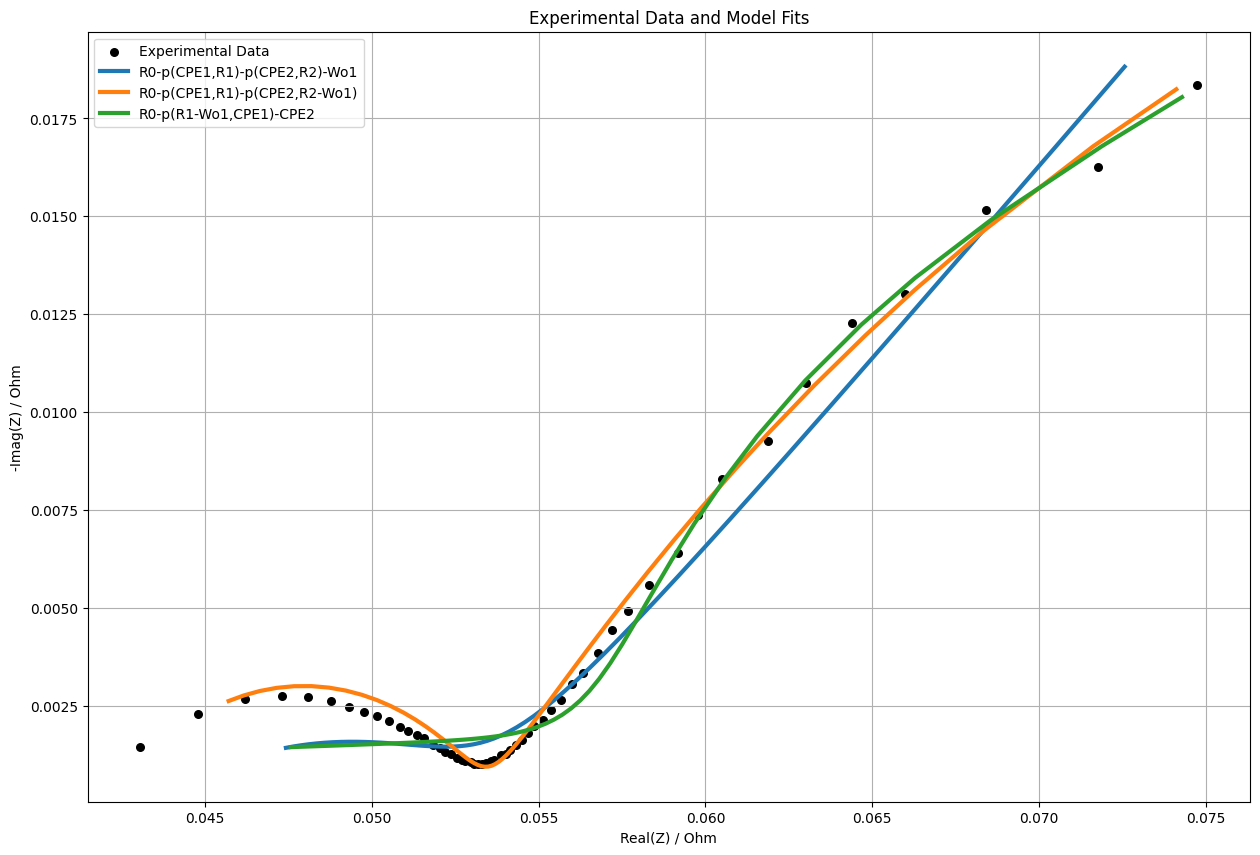

Parameters for circuit R0-p(CPE1,R1)-p(CPE2,R2)-Wo1: [4.36313863e-02 1.03232163e+01 3.55503342e-01 5.32572548e-03
 1.08371996e+01 3.55457581e-01 5.07165887e-03 3.80062496e-01
 3.52416902e+03]
MSE for circuit R0-p(CPE1,R1)-p(CPE2,R2)-Wo1: 1.4231750278612988e-06
Parameters for circuit R0-p(CPE1,R1)-p(CPE2,R2-Wo1): [4.23542454e-02 4.08133260e-01 6.27855436e-01 1.10581796e-02
 1.61582403e+02 5.96474834e-01 1.04251603e-01 1.46439414e-10
 2.06956439e+02]
MSE for circuit R0-p(CPE1,R1)-p(CPE2,R2-Wo1): 3.2713384133948027e-07
Parameters for circuit R0-p(R1-Wo1,CPE1)-CPE2: [9.23203094e-15 1.68048925e-02 1.81964304e-01 2.16797293e+03
 4.00558106e+02 1.00000000e+00 1.74534882e+01 1.92393173e-02]
MSE for circuit R0-p(R1-Wo1,CPE1)-CPE2: 1.2559714711443078e-06


In [ ]:
# Plotting Z and model data
plt.figure(figsize=(15, 10), dpi = 100)
plt.scatter(df_NX001_2108_103['Re(Z)/Ohm'], df_NX001_2108_103['-Im(Z)/Ohm'], color='black', s=30, label='Experimental Data')
for model_data, _, circuit, _ in all_model_data:
    plt.plot(np.real(model_data), -np.imag(model_data), '-', label=circuit, linewidth=3)
plt.xlabel('Real(Z) / Ohm')
plt.ylabel('-Imag(Z) / Ohm')
plt.title('Experimental Data and Model Fits')
plt.legend()
plt.grid(True)
plt.show()

for model_data, fitted_params, circuit, mse in all_model_data:
    print(f'Parameters for circuit {circuit}: {fitted_params}')
    print(f'MSE for circuit {circuit}: {mse}')

In [ ]:
#circuit = 'R0-p(CPE1,R1-Wo1)-p(CPE2,R2)-R3-p(R4,C0)-R5-p(R6,CPE3)-p(R7-Wo2, C1)-R8'

#model_data, fitted_params, mse = fit_ecm_model(df_NX001_2108_103, circuit, 21)

# Plotting Z and model data
#plt.figure(figsize=(10, 6), dpi = 50)
#plt.plot(np.real(model_data), -np.imag(model_data), '-', label=circuit)
#plt.scatter(df_NX001_2108_103['Re(Z)/Ohm'], df_NX001_2108_103['-Im(Z)/Ohm'], color='black', s=8, label='Experimental Data')
#plt.xlabel('Real(Z) / Ohm')
#plt.ylabel('-Imag(Z) / Ohm')
#plt.title('Experimental Data and Model Fits')
#plt.legend()
#plt.grid(True)
#plt.show()

#for model_data, fitted_params, circuit, mse in all_model_data:
    #print(f'Parameters for circuit {circuit}: {fitted_params}')
    #print(f'MSE for circuit {circuit}: {mse}')

### Thoughts and next steps

impedance.py is very streamlined, but its very slow for complex circuit models. Unless there's a way to speed it up, it probably won't be the best option to use.

**To do:**
- Do more research on ECMs, and gather a selection to try
- Look into ways of speeding up impedance or look into writing own piece of code to do what it does
- Consider making a function that iterates through lots of ECMs and outputs the best one, might not be worth the time
- Compare MSEs for different ECMs
- Document findings
- Determine the physical link between equivalent circuit components and battery components

## Let's investigate other options
Pre-existing Python Packages:
- EIS (Electrochemical Impedance Spectroscopy) by Zhi-Gang Wang
- scipy.optimize.curve_fit

### Using scipy.optimize:

In [10]:
# Define the elements of the circuit model
def Z_R(R, omega):
    """
    Calculate the impedance of a resistor.

    Parameters:
    R (float): Resistance value.
    omega (float): Angular frequency.
    
    Returns:
    complex: Impedance of the resistor.
    """

    return R

def Z_CPE(Q, n, omega):
    """
    Calculate the impedance of a constant phase element.

    Parameters:
    Q (float): Constant phase element parameter.
    n (float): Constant phase element parameter.
    omega (float): Angular frequency.

    Returns:
    complex: Impedance of the constant phase element.
    """
    epsilon = 1e-8
    return 1 / (Q * (1j * omega + epsilon)**n)

def Z_W(A, omega):
    """
    Calculate the impedance of a Warburg element.

    Parameters:
    A (float): Warburg element parameter.
    omega (float): Angular frequency.

    Returns:
    complex: Impedance of the Warburg element.
    """
    epsilon = 1e-8
    return A / np.sqrt(1j * omega + epsilon)

# Define the full circuit model: R0-p(CPE1,R1)-p(CPE2,R2-Wo1)
def circuit_model(freq, R0, Q1, n1, R1, Q2, n2, R2, A):
    """
    Calculate the impedance of the full circuit model.

    Parameters:
    freq (float): Frequency.
    R0 (float): Resistance value.
    Q1 (float): Constant phase element parameter.
    n1 (float): Constant phase element parameter.
    R1 (float): Resistance value.
    Q2 (float): Constant phase element parameter.
    n2 (float): Constant phase element parameter.
    R2 (float): Resistance value.
    A (float): Warburg element parameter.

    Returns:
    np.array: Real and imaginary parts of the impedance.
    """

    omega = 2 * np.pi * freq
    Z_R0 = Z_R(R0, omega)
    Z_CPE1_R1 = 1 / (1 / Z_CPE(Q1, n1, omega) + 1 / Z_R(R1, omega))
    Z_R2_Wo1 = Z_R(R2, omega) + Z_W(A, omega)
    Z_CPE2_R2_Wo1 = 1 / (1 / Z_CPE(Q2, n2, omega) + 1 / Z_R2_Wo1)
    Z_total = Z_R0 + Z_CPE1_R1 + Z_CPE2_R2_Wo1
    return np.concatenate((Z_total.real, Z_total.imag))

Optimized parameters: [0.04439674 0.02429772 1.00118993 0.00650554 0.99996657 0.99980543
 0.00199657 0.00671809]
Mean Squared Error (MSE): 4.4005099207808413e-07


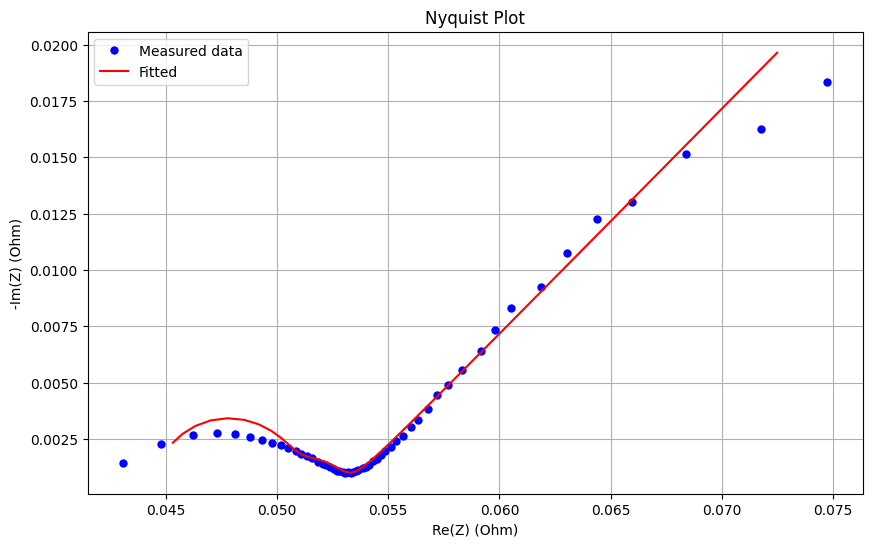

In [11]:
# Load data
df = df_NX001_2108_103[["|Z|/Ohm", "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm", "cycle number"]]
frequencies = df["freq/Hz"].values
Z_real = df["Re(Z)/Ohm"].values
Z_imag = -df["-Im(Z)/Ohm"].values
Z_data = np.concatenate((Z_real, Z_imag))

# Define the objective function (mean squared error)
def objective_function(params):
    fitted_Z = circuit_model(frequencies, *params)
    fitted_Z_real = fitted_Z[:len(frequencies)]
    fitted_Z_imag = fitted_Z[len(frequencies):]
    mse = np.mean((fitted_Z_real - Z_real)**2 + (fitted_Z_imag - Z_imag)**2)
    return mse

# Define initial guess
initial_guess = [0.05, 0.01, 1, 0.01, 1, 1, 0.001, 0.005]

# Optimize initial conditions
result = minimize(objective_function, initial_guess)
optimized_params = result.x

# Print optimized parameters and MSE
print("Optimized parameters:", optimized_params)
print("Mean Squared Error (MSE):", result.fun)

# Plotting
fitted_Z = circuit_model(frequencies, *optimized_params)
fitted_Z_real = fitted_Z[:len(frequencies)]
fitted_Z_imag = fitted_Z[len(frequencies):]

plt.figure(figsize=(10, 6), dpi = 100)
plt.plot(Z_real, -Z_imag, 'bo', label='Measured data', markersize=5)    
plt.plot(fitted_Z_real, -fitted_Z_imag, 'r-', label='Fitted')
plt.xlabel('Re(Z) (Ohm)')
plt.ylabel('-Im(Z) (Ohm)')
plt.legend()
plt.title('Nyquist Plot')
plt.grid(True)
plt.show()


Clearly, there is something going wrong with the fitting, as the curve is fitting well in the densely populated region but much less well on the left and right of this region where there is less data.

This is likely due to the MSE being evenly weighted, so it can reach the tolerance by fitting well in the area where there are more data points, and less well where there are fewer data points and hence less penalty is small. In the following code, I define a weight array `weights` that assigns a weight of 0.1 to the data points in the mid-section (between 0.0473 and 0.0583 Re(Z)/Ohm). This reduces the influence of these points on the MSE calculation, addressing the over-weighting issue. This solution is not ideal, as it won't work for every cycle, so my next step would be to implement code that identifies a region with more data points so it can assign weighting autonomously.

Optimized parameters: [0.04439674 0.02429772 1.00118993 0.00650554 0.99996657 0.99980543
 0.00199657 0.00671809]
Mean Squared Error (MSE): 4.4005099207808413e-07


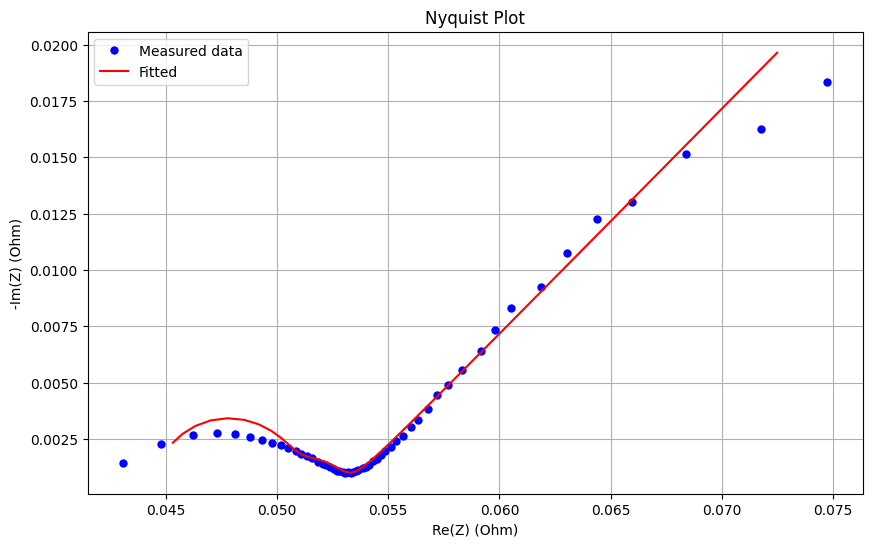

In [12]:
# Define the objective function (weighted mean squared error)
def objective_function_weighted(params):
    fitted_Z = circuit_model(frequencies, *params)
    fitted_Z_real = fitted_Z[:len(frequencies)]
    fitted_Z_imag = fitted_Z[len(frequencies):]
    
    # Define weights
    weights = np.ones_like(Z_real)
    mid_section_mask = (Z_real >= 0.0473) & (Z_real <= 0.0583)
    weights[mid_section_mask] = 0.1  # Less weight for points in the mid-section
    
    mse = np.mean(weights * ((fitted_Z_real - Z_real)**2 + (fitted_Z_imag - Z_imag)**2))
    return mse

# Define initial guess
initial_guess = [0.05, 0.01, 1, 0.01, 1, 1, 0.001, 0.005]

# Optimize initial conditions
result = minimize(objective_function, initial_guess)
optimized_params = result.x

# Print optimized parameters and MSE
print("Optimized parameters:", optimized_params)
print("Mean Squared Error (MSE):", result.fun)

# Plotting
fitted_Z = circuit_model(frequencies, *optimized_params)
fitted_Z_real = fitted_Z[:len(frequencies)]
fitted_Z_imag = fitted_Z[len(frequencies):]

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(Z_real, -Z_imag, 'bo', label='Measured data', markersize=5)
plt.plot(fitted_Z_real, -fitted_Z_imag, 'r-', label='Fitted')
plt.xlabel('Re(Z) (Ohm)')
plt.ylabel('-Im(Z) (Ohm)')
plt.legend()
plt.title('Nyquist Plot')
plt.grid(True)
plt.show()


Optimized parameters: [0.04439674 0.02429772 1.00118993 0.00650554 0.99996657 0.99980543
 0.00199657 0.00671809]
Mean Squared Error (MSE): 4.4005099207808413e-07


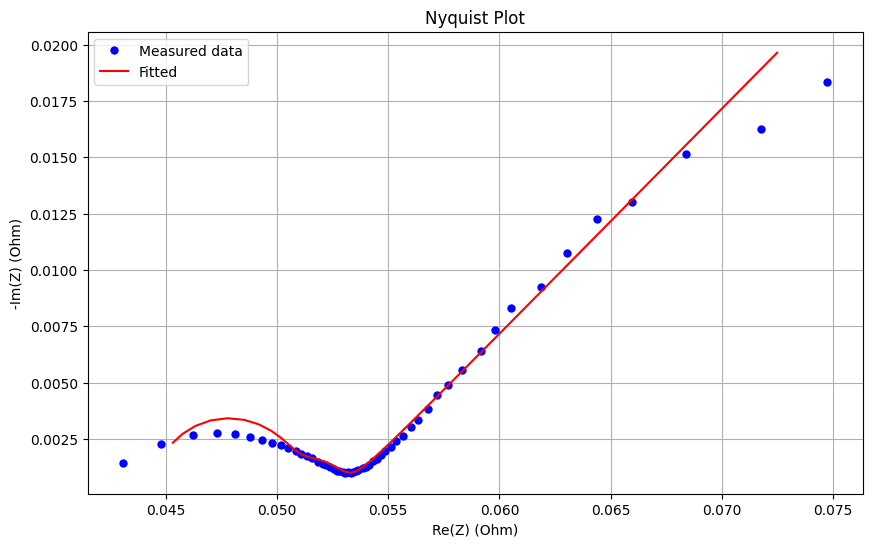

In [13]:
from scipy.spatial import cKDTree

# Load data
df = df_NX001_2108_103[["|Z|/Ohm", "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm", "cycle number"]]
frequencies = df["freq/Hz"].values
Z_real = df["Re(Z)/Ohm"].values
Z_imag = -df["-Im(Z)/Ohm"].values
Z_data = np.column_stack((Z_real, Z_imag)) 

# Compute weights based on nearest neighbor distances
tree = cKDTree(Z_data)
distances, _ = tree.query(Z_data, k=2)
weights = distances[:, 1]  # Distance to the nearest neighbor
weights = weights / np.max(weights)  # Normalize weights

# Define the objective function (weighted mean squared error)
def objective_function_all_weighted(params):
    fitted_Z = circuit_model(frequencies, *params)
    fitted_Z_real = fitted_Z[:len(frequencies)]
    fitted_Z_imag = fitted_Z[len(frequencies):]
    
    mse = np.mean(weights * ((fitted_Z_real - Z_real)**2 + (fitted_Z_imag - Z_imag)**2))
    return mse

# Define initial guess
initial_guess = [0.05, 0.01, 1, 0.01, 1, 1, 0.001, 0.005]

# Optimize initial conditions
result = minimize(objective_function, initial_guess)
optimized_params = result.x

# Print optimized parameters and MSE
print("Optimized parameters:", optimized_params)
print("Mean Squared Error (MSE):", result.fun)

# Plotting
fitted_Z = circuit_model(frequencies, *optimized_params)
fitted_Z_real = fitted_Z[:len(frequencies)]
fitted_Z_imag = fitted_Z[len(frequencies):]

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(Z_real, -Z_imag, 'bo', label='Measured data', markersize=5)
plt.plot(fitted_Z_real, -fitted_Z_imag, 'r-', label='Fitted')
plt.xlabel('Re(Z) (Ohm)')
plt.ylabel('-Im(Z) (Ohm)')
plt.legend()
plt.title('Nyquist Plot')
plt.grid(True)
plt.show()


Optimized parameters: [0.04416219 0.0273884  1.00159762 0.00650722 0.99998272 0.99986876
 0.00213954 0.00675237]
Mean Squared Error (MSE): 6.607334449570627e-07


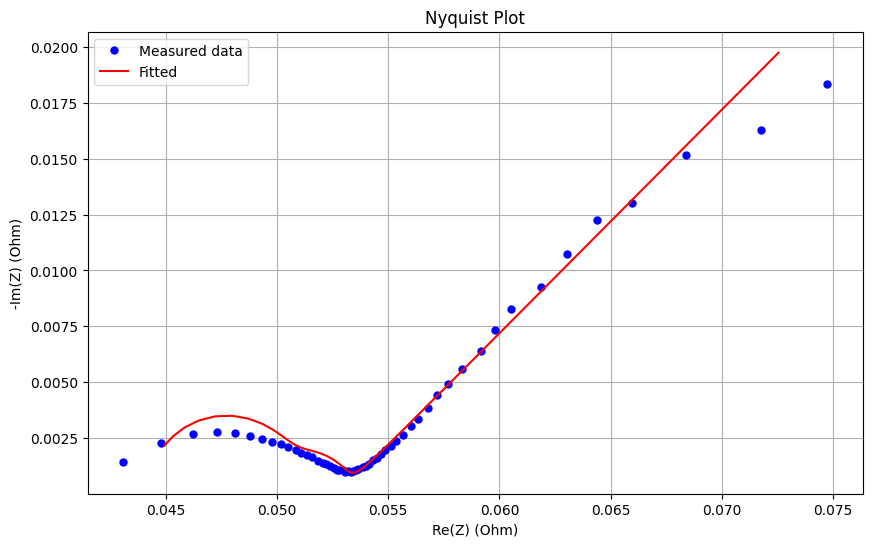

In [ ]:

# Define the densely populated region
dense_region_min = 0.0473
dense_region_max = 0.0583

# Identify points in the dense region
dense_indices = (Z_real >= dense_region_min) & (Z_real <= dense_region_max)
sparse_indices = ~dense_indices

# Sample a subset of points from the dense region
np.random.seed(42)  # For reproducibility
sampled_dense_indices = np.random.choice(np.where(dense_indices)[0], size=int(0.4 * np.sum(dense_indices)), replace=False)

# Combine the sampled dense points with the sparse points
selected_indices = np.concatenate((sampled_dense_indices, np.where(sparse_indices)[0]))
selected_frequencies = frequencies[selected_indices]
selected_Z_real = Z_real[selected_indices]
selected_Z_imag = Z_imag[selected_indices]

# Define the objective function (mean squared error)
def objective_function(params):
    fitted_Z = circuit_model(selected_frequencies, *params)
    fitted_Z_real = fitted_Z[:len(selected_frequencies)]
    fitted_Z_imag = fitted_Z[len(selected_frequencies):]
    
    mse = np.mean((fitted_Z_real - selected_Z_real)**2 + (fitted_Z_imag - selected_Z_imag)**2)
    return mse

# Define initial guess and bounds
initial_guess = [0.05, 0.01, 1, 0.01, 1, 1, 0.001, 0.005]

# Optimize initial conditions with a different algorithm and bounds
result = minimize(objective_function, initial_guess)
optimized_params = result.x

# Print optimized parameters and MSE
print("Optimized parameters:", optimized_params)
print("Mean Squared Error (MSE):", result.fun)

# Plotting
fitted_Z = circuit_model(frequencies, *optimized_params)
fitted_Z_real = fitted_Z[:len(frequencies)]
fitted_Z_imag = fitted_Z[len(frequencies):]

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(Z_real, -Z_imag, 'bo', label='Measured data', markersize=5)
plt.plot(fitted_Z_real, -fitted_Z_imag, 'r-', label='Fitted')
plt.xlabel('Re(Z) (Ohm)')
plt.ylabel('-Im(Z) (Ohm)')
plt.legend()
plt.title('Nyquist Plot')
plt.grid(True)
plt.show()

This hasn't solved the issue, so instead, I tried a more complex approach using Scipy's kernel density estimator (KDE). The idea of this is to produce a probability density function that describes where the points lie, so that the sampling can be performed in a manner that is proportional to the density of data. This way, the data is evenly weighted in the optimisation algorithm.

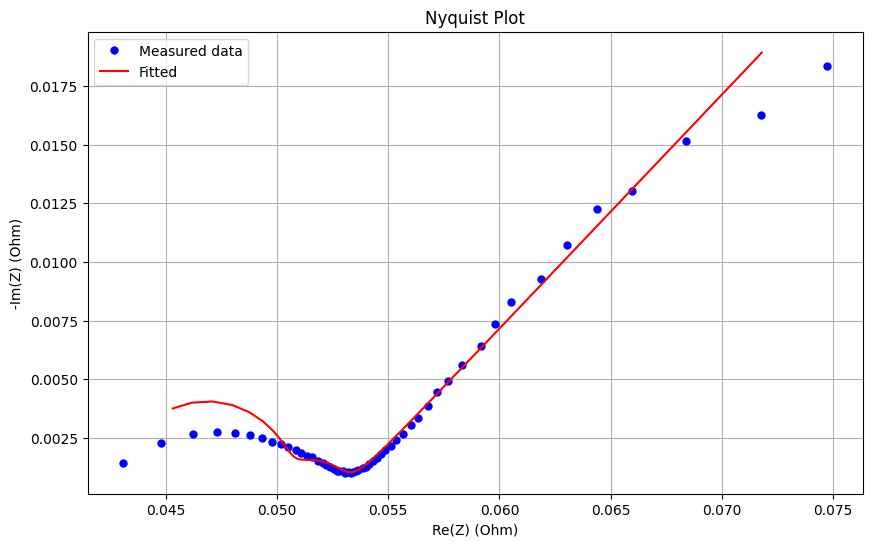

Optimized parameters: [0.04280124 0.01201085 1.00014562 0.0079092  0.99999526 0.99997134
 0.00220245 0.00647428]
Mean Squared Error (MSE): 1.2983611895269552e-07


In [14]:
# First attempt
from sklearn.neighbors import KernelDensity
def fit_circuit_model(df, circuit_model, initial_guess, bandwidth=0.001, sampling_ratio=0.5):
    """
    Fits a circuit model to impedance data using Kernel Density Estimation for sampling.

    Parameters:
        df (DataFrame): DataFrame containing impedance data with columns "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm".
        circuit_model (function): Circuit model function to fit the data.
        initial_guess (list): Initial guess for the parameters of the circuit model.
        bandwidth (float, optional): Bandwidth parameter for Kernel Density Estimation. Default is 0.001.
        sampling_ratio (float, optional): Ratio of sampled points to total points. Default is 0.8.

    Returns:
        optimized_params (array): Optimized parameters of the circuit model.
        mse (float): Mean squared error of the fit.
    """
    
    # Extract data
    frequencies = df["freq/Hz"].values
    Z_real = df["Re(Z)/Ohm"].values
    Z_imag = -df["-Im(Z)/Ohm"].values
    
    # Perform Kernel Density Estimation on Re(Z)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Z_real[:, None])
    log_densities = kde.score_samples(Z_real[:, None])
    densities = np.exp(log_densities)
    
    # Normalise densities to create sampling probabilities
    sampling_probabilities = densities / densities.sum()
    
    # Sample points based on the computed probabilities
    num_samples = int(sampling_ratio * len(Z_real))
    np.random.seed(42)  # For reproducibility
    sampled_indices = np.random.choice(len(Z_real), size=num_samples, replace=False, p=sampling_probabilities)
    
    # Select sampled points
    selected_frequencies = frequencies[sampled_indices]
    selected_Z_real = Z_real[sampled_indices]
    selected_Z_imag = Z_imag[sampled_indices]
    
    # Define the objective function (mean squared error)
    def objective_function(params):
        fitted_Z = circuit_model(selected_frequencies, *params)
        fitted_Z_real = fitted_Z[:len(selected_frequencies)]
        fitted_Z_imag = fitted_Z[len(selected_frequencies):]

        mse = np.mean((fitted_Z_real - selected_Z_real)**2 + (fitted_Z_imag - selected_Z_imag)**2)
        return mse
    
    # Optimise initial conditions with a separate algorithm and bounds
    result = minimize(objective_function, initial_guess)
    optimized_params = result.x
    
    # Plotting
    fitted_Z = circuit_model(frequencies, *optimized_params)
    fitted_Z_real = fitted_Z[:len(frequencies)]
    fitted_Z_imag = fitted_Z[len(frequencies):]

    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(Z_real, -Z_imag, 'bo', label='Measured data', markersize=5)
    plt.plot(fitted_Z_real, -fitted_Z_imag, 'r-', label='Fitted')
    plt.xlabel('Re(Z) (Ohm)')
    plt.ylabel('-Im(Z) (Ohm)')
    plt.legend()
    plt.title('Nyquist Plot')
    plt.grid(True)
    plt.show()
    
    return optimized_params, result.fun

df = df_NX001_2108_103[["|Z|/Ohm", "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm", "cycle number"]]
initial_guess = [0.05, 0.01, 1, 0.01, 1, 1, 0.001, 0.005]

optimized_params, mse = fit_circuit_model(df, circuit_model, initial_guess)
print("Optimized parameters:", optimized_params)
print("Mean Squared Error (MSE):", mse)


Optimized parameters: [3.88458183e-02 5.00069723e-01 5.00322090e-01 1.41151565e-02
 5.00000101e-01 5.00000375e-01 1.86965882e-04 6.32940338e-03]
Mean Squared Error (MSE): 8.462824709318292e-07


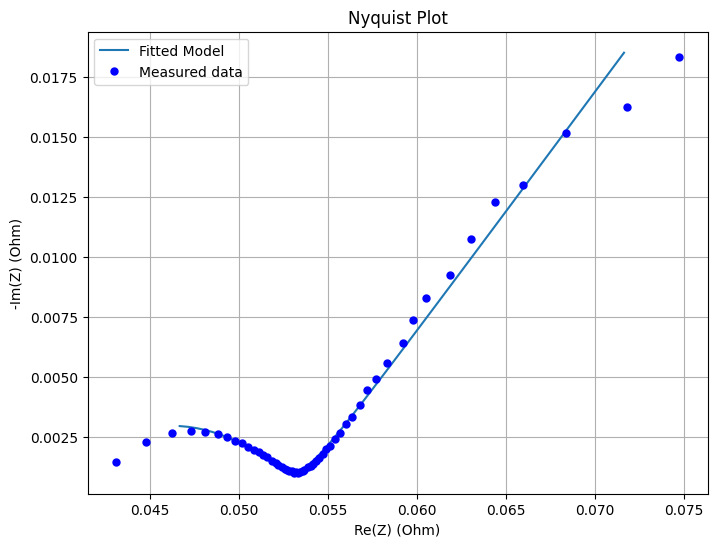

In [26]:
#Improved effort
def fit_circuit_model_KDE(df, circuit_model, initial_guesses, bandwidth=0.001, sampling_ratio=1):
    """
    Fits a circuit model to impedance data using Kernel Density Estimation for sampling.

    Parameters:
        df (DataFrame): DataFrame containing impedance data with columns "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm".
        circuit_model (function): Circuit model function to fit the data.
        initial_guesses (list): List of initial guesses for the parameters of the circuit model.
        bandwidth (float, optional): Bandwidth parameter for Kernel Density Estimation. Default is 0.001.
        sampling_ratio (float, optional): Ratio of sampled points to total points. Default is 1 (no sampling).

    Returns:
        optimized_params (list): Optimized parameters for the circuit model.
        mse (float): Mean squared error for the circuit model.
    """

    frequencies = df["freq/Hz"].values
    Z_real = df["Re(Z)/Ohm"].values
    Z_imag = -df["-Im(Z)/Ohm"].values

    # Perform Kernel Density Estimation on Re(Z)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Z_real[:, None])
    log_densities = kde.score_samples(Z_real[:, None])
    densities = np.exp(log_densities)
    
    # Normalize densities to create sampling probabilities
    sampling_probabilities = densities / densities.sum()
    
    # Sample points based on the computed probabilities
    num_samples = int(sampling_ratio * len(Z_real))
    np.random.seed(42)  # For reproducibility
    sampled_indices = np.random.choice(len(Z_real), size=num_samples, replace=False, p=sampling_probabilities)
    
    # Select sampled points
    selected_frequencies = frequencies[sampled_indices]
    selected_Z_real = Z_real[sampled_indices]
    selected_Z_imag = Z_imag[sampled_indices]
    
    # Define the objective function (mean squared error)
    def objective_function(params):
        fitted_Z = circuit_model(selected_frequencies, *params)
        fitted_Z_real = fitted_Z[:len(selected_frequencies)]
        fitted_Z_imag = fitted_Z[len(selected_frequencies):]

        mse = np.mean((fitted_Z_real - selected_Z_real)**2 + (fitted_Z_imag - selected_Z_imag)**2)
        return mse
    
    # Define bounds for each parameter (greater than zero and realistic numbers)
    bounds = [(1e-6, None) for _ in range(len(initial_guesses))]

    # Optimize initial conditions with bounds
    result = minimize(objective_function, initial_guesses, bounds=bounds)
    optimized_params = result.x
    
    # Calculate MSE on the full data
    fitted_Z_full = circuit_model(frequencies, *optimized_params)
    fitted_Z_real_full = fitted_Z_full[:len(frequencies)]
    fitted_Z_imag_full = fitted_Z_full[len(frequencies):]
    mse_full = np.mean((fitted_Z_real_full - Z_real)**2 + (fitted_Z_imag_full - Z_imag)**2)

    # Print optimized parameters and MSE
    print(f"Optimized parameters: {optimized_params}")
    print(f"Mean Squared Error (MSE): {mse_full}")
    
    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

    plt.plot(fitted_Z_real_full, -fitted_Z_imag_full, label='Fitted Model')

    plt.plot(Z_real, -Z_imag, 'bo', label='Measured data', markersize=5)
    plt.xlabel('Re(Z) (Ohm)')
    plt.ylabel('-Im(Z) (Ohm)')
    plt.legend()
    plt.title('Nyquist Plot')
    plt.grid(True)
    plt.show()

    return optimized_params, mse_full

def circuit_model_1(freq, *params):
    R0, Q1, n1, R1, Q2, n2, R2, A = params[:8]
    omega = 2 * np.pi * freq
    Z_R0 = Z_R(R0, omega)
    Z_CPE1_R1 = 1 / (1 / Z_CPE(Q1, n1, omega) + 1 / Z_R(R1, omega))
    Z_CPE2_R2 = 1 / (1 / Z_CPE(Q2, n2, omega) + 1 / Z_R(R2, omega))
    Z_Wo1 = Z_W(A, omega)
    Z_total = Z_R0 + Z_CPE1_R1 + Z_CPE2_R2 + Z_Wo1
    return np.concatenate((Z_total.real, Z_total.imag))

initial_guesses = [0.05, 0.5, 0.5, 0.005, 0.5, 0.5, 0.0005, 0.005]

optimized_params, mse = fit_circuit_model_KDE(df, circuit_model_1, initial_guesses, bandwidth=0.001, sampling_ratio=0.5) #Change sampling ratio here


Compare to other circuits...

Optimized parameters for R0-p(R1,CPE1)-p(R2-Wo1,CPE2): [3.91720884e-02 5.00066234e-01 5.00290557e-01 1.39325138e-02
 5.00000054e-01 5.00000203e-01 1.00000000e-06 6.36932181e-03]
Optimized parameters for R0-p(R1,C)-Wo1: [0.04705861 0.0054564  0.06872547 0.00667941]
Optimized parameters for R0-p(R1,C)-p(R2,C)-Wo1: [0.04080575 0.00033844 0.00298593 0.01092663 0.00912392 0.00698012]


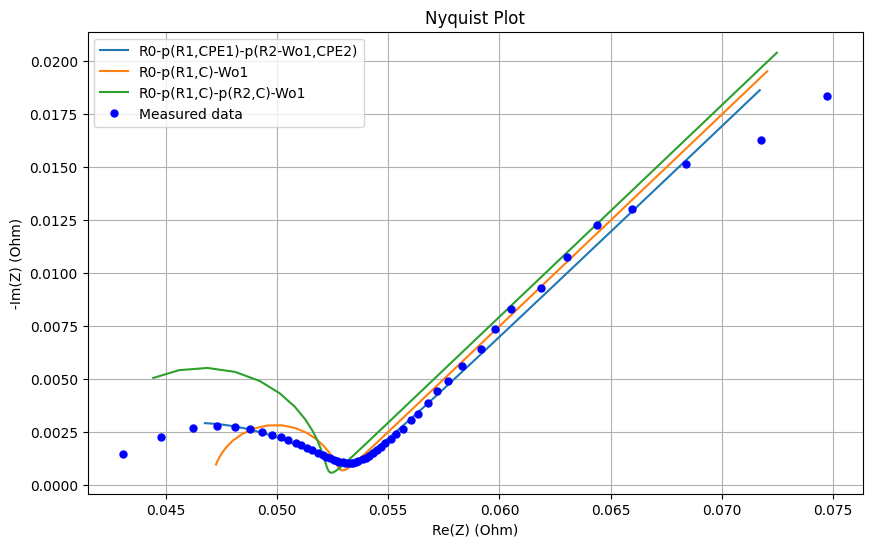

In [24]:
def fit_multiple_circuit_models(df, circuit_models, initial_guesses, bandwidth=0.001, sampling_ratio=1):
    """
    Fits multiple circuit models to impedance data using Kernel Density Estimation for sampling.

    Parameters:
        df (DataFrame): DataFrame containing impedance data with columns "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm".
        circuit_models (list): List of circuit model functions to fit the data.
        initial_guesses (list): List of initial guesses for the parameters of each circuit model.
        bandwidth (float, optional): Bandwidth parameter for Kernel Density Estimation. Default is 0.001.
        sampling_ratio (float, optional): Ratio of sampled points to total points. Default is 0.8.

    Returns:
        optimized_params_list (list): List of optimized parameters for each circuit model.
        mse_list (list): List of mean squared errors for each circuit model.
    """
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

    frequencies = df["freq/Hz"].values
    Z_real = df["Re(Z)/Ohm"].values
    Z_imag = -df["-Im(Z)/Ohm"].values
    num_models = len(circuit_models)
    
    optimized_params_list = []
    mse_list = []

    for i in range(num_models):
        # Perform Kernel Density Estimation on Re(Z)
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Z_real[:, None])
        log_densities = kde.score_samples(Z_real[:, None])
        densities = np.exp(log_densities)
        
        # Normalize densities to create sampling probabilities
        sampling_probabilities = densities / densities.sum()
        
        # Sample points based on the computed probabilities
        num_samples = int(sampling_ratio * len(Z_real))
        np.random.seed(42)  # For reproducibility
        sampled_indices = np.random.choice(len(Z_real), size=num_samples, replace=False, p=sampling_probabilities)
        
        # Select sampled points
        selected_frequencies = frequencies[sampled_indices]
        selected_Z_real = Z_real[sampled_indices]
        selected_Z_imag = Z_imag[sampled_indices]
        
        # Define the objective function (mean squared error)
        def objective_function(params):
            fitted_Z = circuit_models[i](selected_frequencies, *params)
            fitted_Z_real = fitted_Z[:len(selected_frequencies)]
            fitted_Z_imag = fitted_Z[len(selected_frequencies):]

            mse = np.mean((fitted_Z_real - selected_Z_real)**2 + (fitted_Z_imag - selected_Z_imag)**2)
            return mse
        
        # Define bounds for each parameter (greater than zero and realistic numbers)
        bounds = [(1e-6, None) for _ in range(len(initial_guesses[i]))]

        # Optimize initial conditions with bounds
        result = minimize(objective_function, initial_guesses[i], bounds=bounds)
        optimized_params = result.x
        
        # Print optimized parameters for the current model
        print(f"Optimized parameters for {get_model_name(circuit_models[i])}: {optimized_params}")
        
        optimized_params_list.append(optimized_params)
        mse_list.append(result.fun)

        # Plotting
        model_name = get_model_name(circuit_models[i])
        fitted_Z = circuit_models[i](frequencies, *optimized_params)
        fitted_Z_real = fitted_Z[:len(frequencies)]
        fitted_Z_imag = fitted_Z[len(frequencies):]

        plt.plot(fitted_Z_real, -fitted_Z_imag, label=model_name)

    plt.plot(Z_real, -Z_imag, 'bo', label='Measured data', markersize=5)
    plt.xlabel('Re(Z) (Ohm)')
    plt.ylabel('-Im(Z) (Ohm)')
    plt.legend()
    plt.title('Nyquist Plot')
    plt.grid(True)
    plt.show()

    return optimized_params_list, mse_list

def get_model_name(model_function):
    if model_function.__name__ == 'circuit_model_2':
        return 'R0-p(R1,CPE1)-p(R2-Wo1,CPE2)'
    elif model_function.__name__ == 'circuit_model_3':
        return 'R0-p(R1,C)-Wo1'
    elif model_function.__name__ == 'circuit_model_4':
        return 'R0-p(R1,C)-p(R2,C)-Wo1'
    else:
        return 'Unknown Model'

def circuit_model_2(freq, *params):
    R0, Q1, n1, R1, Q2, n2, R2, A = params[:8]
    omega = 2 * np.pi * freq
    Z_R0 = Z_R(R0, omega)
    Z_CPE1_R1 = 1 / (1 / Z_CPE(Q1, n1, omega) + 1 / Z_R(R1, omega))
    Z_CPE2_R2 = 1 / (1 / Z_CPE(Q2, n2, omega) + 1 / Z_R(R2, omega))
    Z_Wo1 = Z_W(A, omega)
    Z_total = Z_R0 + Z_CPE1_R1 + Z_CPE2_R2 + Z_Wo1
    return np.concatenate((Z_total.real, Z_total.imag))

def circuit_model_3(freq, *params):
    R0, R1, C1, A = params[:4]
    omega = 2 * np.pi * freq
    Z_R0 = R0
    Z_RC1 = R1 / (1 + 1j * omega * R1 * C1)
    Z_Wo1 = A / np.sqrt(1j * omega)
    Z_total = Z_R0 + Z_RC1 + Z_Wo1
    return np.concatenate((Z_total.real, Z_total.imag))

def circuit_model_4(freq, *params):
    R0, R1, C1, R2, C2, A = params[:6]
    omega = 2 * np.pi * freq
    Z_R0 = R0
    Z_RC1 = R1 / (1 + 1j * omega * R1 * C1)
    Z_RC2 = R2 / (1 + 1j * omega * R2 * C2)
    Z_Wo1 = A / np.sqrt(1j * omega)
    Z_total = Z_R0 + Z_RC1 + Z_RC2 + Z_Wo1
    return np.concatenate((Z_total.real, Z_total.imag))

circuit_models = [circuit_model_2, circuit_model_3, circuit_model_4]

initial_guesses = [
    # For circuit_model_2
    [0.05, 0.5, 0.5, 0.005, 0.5, 0.5, 0.0005, 0.005],
    # For circuit_model_3
    [0.05, 0.005, 0.00005, 0.005],
    # For circuit_model_4
    [0.05, 0.005, 0.00005, 0.005, 0.005, 0.00005],
]

optimized_params, mse = fit_multiple_circuit_models(df, circuit_models, initial_guesses, bandwidth=0.001, sampling_ratio=0.8)


Optimized parameters for R0-p(R1,CPE1)-p(R2-Wo1,CPE2): [1.58180734e-08 5.23023951e-02 9.51562133e-01 6.07619460e-03
 5.22929020e+00 2.71328091e-02 6.39012603e-02 9.15819312e-03]
Optimized parameters for R0-p(R1,C)-p(R2,C)-Wo1: [0.04441771 0.00657951 0.02776501 0.00174212 1.60765086 0.006488  ]
Optimized parameters for R0-p(R1,CPE1)-p(R2,C)-Wo1: [4.34134640e-02 1.32705716e+00 9.35335953e-01 2.18696937e-04
 1.79309493e-01 7.64712176e-01 8.99984830e-03 6.65539964e-03]


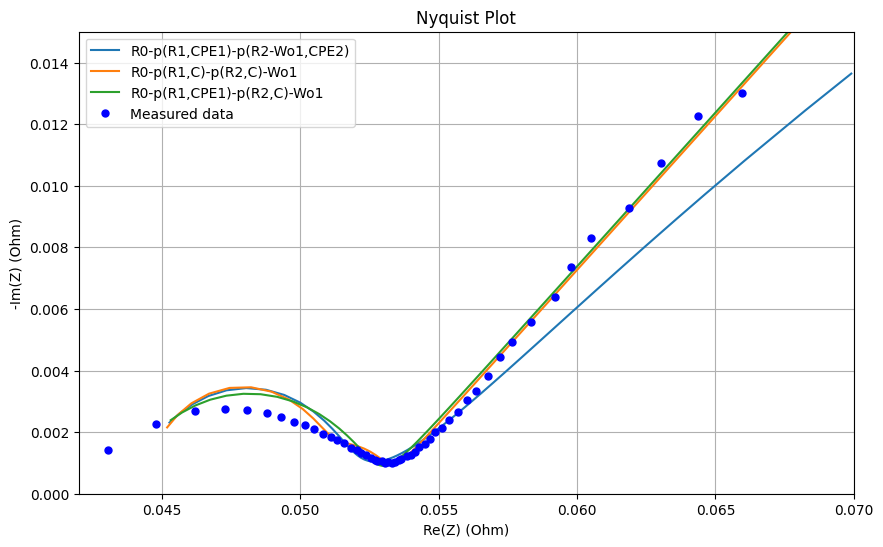

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit_multiple_circuit_models(df, circuit_models, initial_guesses, n=4, use_kde=True, bandwidth=0.001, sampling_ratio=0.2):
    """
    Fits multiple circuit models to impedance data using curve_fit or KDE for sampling.

    Parameters:
        df (DataFrame): DataFrame containing impedance data with columns "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm".
        circuit_models (list): List of circuit model functions to fit the data.
        initial_guesses (list): List of initial guesses for the parameters of each circuit model.
        use_kde (bool, optional): Whether to use Kernel Density Estimation for sampling. Default is True.

    Returns:
        optimized_params_list (list): List of optimized parameters for each circuit model.
        mse_list (list): List of mean squared errors for each circuit model.
    """
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

    frequencies = df["freq/Hz"].values
    Z_real = df["Re(Z)/Ohm"].values
    Z_imag = -df["-Im(Z)/Ohm"].values
    num_models = len(circuit_models)
    
    optimized_params_list = []
    mse_list = []

    for i in range(num_models):
        if use_kde:
            # Perform Kernel Density Estimation on Re(Z)
            kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Z_real[:, None])
            log_densities = kde.score_samples(Z_real[:, None])
            densities = np.exp(log_densities)

            # Normalize densities to create sampling probabilities
            sampling_probabilities = densities / densities.sum()

            # Sample points based on the computed probabilities
            num_samples = int(sampling_ratio * len(Z_real))
            np.random.seed(42)  # For reproducibility
            
            # Ensure the first 5 data points are always included
            first_n_indices = np.arange(n)
            other_indices = np.random.choice(len(Z_real) - n, size=num_samples - n, replace=False, p=sampling_probabilities[n:] / sampling_probabilities[n:].sum()) # Normalize probabilities
            sampled_indices = np.concatenate((first_n_indices, other_indices))

            selected_frequencies = frequencies[sampled_indices]
            selected_Z_real = Z_real[sampled_indices]
            selected_Z_imag = Z_imag[sampled_indices]

        else:
            selected_frequencies = frequencies
            selected_Z_real = Z_real
            selected_Z_imag = Z_imag
        
        def objective_function(freq, *params):
            fitted_Z = circuit_models[i](freq, *params)
            fitted_Z_real_selected = fitted_Z[:len(freq)]
            fitted_Z_imag_selected = fitted_Z[len(freq):]
            return np.concatenate((fitted_Z_real_selected, fitted_Z_imag_selected))

        # Optimize initial conditions with curve_fit
        optimized_params, _ = curve_fit(objective_function, selected_frequencies, np.concatenate((selected_Z_real, selected_Z_imag)), p0=initial_guesses[i], bounds=(0, np.inf), maxfev=10000)

        
        # Print optimized parameters for the current model
        print(f"Optimized parameters for {get_model_name(circuit_models[i])}: {optimized_params}")
        
        optimized_params_list.append(optimized_params)
        fitted_values = objective_function(selected_frequencies, *optimized_params)
        mse_list.append(np.mean((fitted_values - np.concatenate((selected_Z_real, selected_Z_imag)))**2))

        # Plotting
        model_name = get_model_name(circuit_models[i])
        fitted_Z = circuit_models[i](frequencies, *optimized_params)
        fitted_Z_real = fitted_Z[:len(frequencies)]
        fitted_Z_imag = fitted_Z[len(frequencies):]

        plt.plot(fitted_Z_real, -fitted_Z_imag, label=model_name)

    plt.plot(Z_real, -Z_imag, 'bo', label='Measured data', markersize=5)
    plt.xlabel('Re(Z) (Ohm)')
    plt.ylabel('-Im(Z) (Ohm)')
    #set xlim and ylim
    plt.xlim(0.042, 0.07)
    plt.ylim(0.0, 0.015)
    plt.legend()
    plt.title('Nyquist Plot')
    plt.grid(True)
    plt.show()

    return optimized_params_list, mse_list

def get_model_name(model_function):
    if model_function.__name__ == 'circuit_model_1':
        return 'R0-p(R1,CPE1)-p(R2-Wo1,CPE2)'
    elif model_function.__name__ == 'circuit_model_2':
        return 'R0-p(R1,C)-p(R2,C)-Wo1'
    elif model_function.__name__ == 'circuit_model_3':
        return 'R0-p(R1,CPE1)-p(R2,C)-Wo1'
    else:
        return 'Unknown Model'

def circuit_model_1(freq, *params):
    R0, Q1, n1, R1, Q2, n2, R2, A = params[:8]
    omega = 2 * np.pi * freq
    Z_R0 = Z_R(R0, omega)
    Z_CPE1_R1 = 1 / (1 / Z_CPE(Q1, n1, omega) + 1 / Z_R(R1, omega))
    Z_R2_Wo1 = Z_R(R2, omega) + Z_W(A, omega)
    Z_CPE2_R2_Wo1 = 1 / (1 / Z_CPE(Q2, n2, omega) + 1 / Z_R2_Wo1)
    Z_total = Z_R0 + Z_CPE1_R1 + Z_CPE2_R2_Wo1
    return np.concatenate((Z_total.real, Z_total.imag))

def circuit_model_2(freq, *params):
    R0, R1, C1, R2, C2, A = params[:6]
    omega = 2 * np.pi * freq
    Z_R0 = R0
    Z_RC1 = R1 / (1 + 1j * omega * R1 * C1)
    Z_RC2 = R2 / (1 + 1j * omega * R2 * C2)
    Z_Wo1 = A / np.sqrt(1j * omega)
    Z_total = Z_R0 + Z_RC1 + Z_RC2 + Z_Wo1
    return np.concatenate((Z_total.real, Z_total.imag))

def circuit_model_3(freq, *params):
    R0, Q1, n1, R1, Q2, n2, R2, A = params[:8]
    omega = 2 * np.pi * freq
    Z_R0 = Z_R(R0, omega)
    Z_CPE1_R1 = 1 / (1 / Z_CPE(Q1, n1, omega) + 1 / Z_R(R1, omega))
    Z_CPE2_R2 = 1 / (1 / Z_CPE(Q2, n2, omega) + 1 / Z_R(R2, omega))
    Z_Wo1 = Z_W(A, omega)
    Z_total = Z_R0 + Z_CPE1_R1 + Z_CPE2_R2 + Z_Wo1
    return np.concatenate((Z_total.real, Z_total.imag))

circuit_models = [circuit_model_1, circuit_model_2, circuit_model_3]

initial_guesses = [
    [0.05, 0.5, 0.5, 0.005, 0.5, 0.5, 0.0005, 0.005],
    [0.05, 0.005, 0.00005, 0.005, 0.005, 0.00005],
    [0.05, 0.5, 0.5, 0.005, 0.5, 0.5, 0.0005, 0.005]
]

optimized_params, mse = fit_multiple_circuit_models(df, circuit_models, initial_guesses, n=5, use_kde=True, sampling_ratio=0.5)


Now apply the ECM to other batteries.

In [ ]:
#@title Extract the specific data required and plot

df = clean_data['RS001_2108']
cycle_103_df = df[df["cycle number"] == 103].reset_index(drop=True)

# Remove the second run of EIS data
freq_diff = cycle_103_df["freq/Hz"].diff().fillna(0)
first_increase_idx = freq_diff[freq_diff > 0].index[0]
df_RS001_2108_103 = cycle_103_df.iloc[:first_increase_idx]

df_RS001_2108_103 = df_RS001_2108_103[["|Z|/Ohm", "freq/Hz", "Re(Z)/Ohm", "-Im(Z)/Ohm", "cycle number"]]

plot_single_spectrum(df_RS001_2108_103, 'RS001_2108', show_frequency_gradient=True)

# Remove rows with negative values in the "-Im(Z)" column
df_RS001_2108_103 = df_RS001_2108_103[df_RS001_2108_103["-Im(Z)/Ohm"] >= 0]

In [ ]:
initial_guesses = [0.05, 0.5, 0.5, 0.005, 0.5, 0.5, 0.0005, 0.005]

optimized_params, mse = fit_circuit_model_KDE(df_RS001_2108_103, circuit_model_1, initial_guesses, bandwidth=0.001, sampling_ratio=0.5) #Change sampling ratio here